In [1]:

# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Step 1: Load and Prepare the Data
df = pd.read_csv('updated_billboard_lyrics_extended.csv')

# Handle NaN values in lyrics (replace NaN with empty strings)
df['lyrics'].fillna('', inplace=True)

# Remove rows where the target label 'explicit' is NaN
df = df.dropna(subset=['explicit'])

# Step 2: Address Class Imbalance by Undersampling
non_explicit_songs = df[df['explicit'] == 0]
explicit_songs = df[df['explicit'] == 1]

# Undersample non-explicit songs to match explicit songs
undersampled_non_explicit = non_explicit_songs.sample(n=len(explicit_songs), random_state=42)

# Combine undersampled non-explicit songs with all explicit songs
df_balanced = pd.concat([undersampled_non_explicit, explicit_songs])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features (target is binary, e.g., 0 or 1)
X_text = df_balanced['lyrics']  # The input text features (lyrics)
X_numerical = df_balanced[['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 
                           'sexual_content_count', 'racial_content_count', 'religious_content_count']]
y = df_balanced['explicit']  # The target label (ensure this is binary, e.g., 0 or 1)


In [3]:
# Step 3: Split into training and testing sets
X_train_text, X_test_text, X_train_numerical, X_test_numerical, y_train, y_test = train_test_split(
    X_text, X_numerical, y, test_size=0.2, random_state=42)

# Step 4: Impute missing values in numerical features
imputer = SimpleImputer(strategy='mean')
X_train_numerical = imputer.fit_transform(X_train_numerical)
X_test_numerical = imputer.transform(X_test_numerical)

# Step 5: Apply Min-Max Scaling to numerical features
scaler = MinMaxScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_test_numerical_scaled = scaler.transform(X_test_numerical)


Naive Bayes Accuracy: 0.8592233009708737
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.78      0.84       101
         1.0       0.82      0.93      0.87       105

    accuracy                           0.86       206
   macro avg       0.87      0.86      0.86       206
weighted avg       0.87      0.86      0.86       206



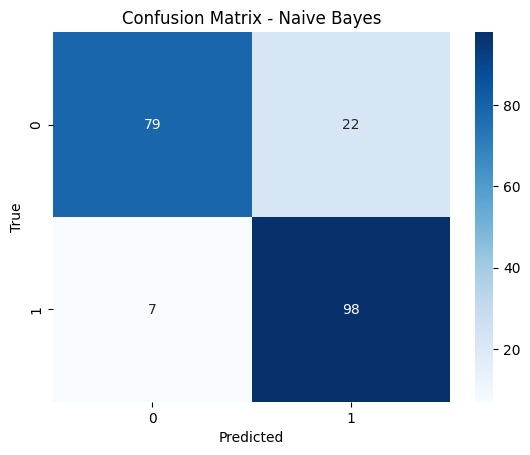

In [4]:
# Step 6: Convert Text into Numerical Representation (TF-IDF for Naive Bayes and KNN)
tfidf = TfidfVectorizer(max_features=5000)  # Adjust the number of features if needed
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# Step 7: Combine TF-IDF text features with scaled numerical features
X_train_combined = hstack([X_train_tfidf, X_train_numerical_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_numerical_scaled])

# Step 8: Train the Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_combined, y_train)

# Predict and Evaluate Naive Bayes
y_pred_nb = nb_model.predict(X_test_combined)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

# Confusion Matrix for Naive Bayes
nb_cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


KNN Accuracy: 0.7961165048543689
Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.83      0.80       101
         1.0       0.82      0.76      0.79       105

    accuracy                           0.80       206
   macro avg       0.80      0.80      0.80       206
weighted avg       0.80      0.80      0.80       206



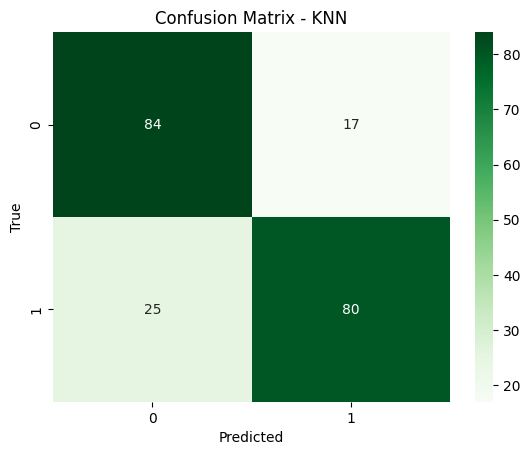

In [5]:
# Step 9: Train the KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_combined, y_train)

# Predict and Evaluate KNN
y_pred_knn = knn_model.predict(X_test_combined)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

# Confusion Matrix for KNN
knn_cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(knn_cm, annot=True, fmt="d", cmap="Greens")
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [6]:
# Step 10: Train the LSTM Model
# Tokenize and pad the sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

max_sequence_length = 300  # Adjust based on your data
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Build LSTM Model
input_text = Input(shape=(max_sequence_length,))
input_numerical = Input(shape=(X_train_numerical_scaled.shape[1],))

# LSTM for text processing
text_embedding = Embedding(input_dim=5000, output_dim=64, input_length=max_sequence_length)(input_text)
text_lstm = LSTM(128)(text_embedding)

# Concatenate text LSTM output with numerical features
combined = Concatenate()([text_lstm, input_numerical])
combined_dense = Dense(64, activation='relu')(combined)
combined_dropout = Dropout(0.5)(combined_dense)
output = Dense(1, activation='sigmoid')(combined_dropout)

# Define the model
model = Model(inputs=[input_text, input_numerical], outputs=output)

# Compile and Train the LSTM Model
history = model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit([X_train_pad, X_train_numerical_scaled], y_train, epochs=5, batch_size=32, validation_data=([X_test_pad, X_test_numerical_scaled], y_test))

# Evaluate LSTM
loss, accuracy = model.evaluate([X_test_pad, X_test_numerical_scaled], y_test)
print(f'LSTM Model Accuracy: {accuracy:.4f}')


Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5580 - loss: 0.6836

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.5586 - loss: 0.6834 - val_accuracy: 0.7039 - val_loss: 0.6617
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.7095 - loss: 0.6465 - val_accuracy: 0.6602 - val_loss: 0.6183
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.7714 - loss: 0.5265 - val_accuracy: 0.7621 - val_loss: 0.5021
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.8787 - loss: 0.3899 - val_accuracy: 0.7476 - val_loss: 0.5743
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.9344 - loss: 0.2432 - val_accuracy: 0.7330 - val_loss: 0.6308
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7485 - loss: 0.6076
LSTM Model Accuracy: 0.7330


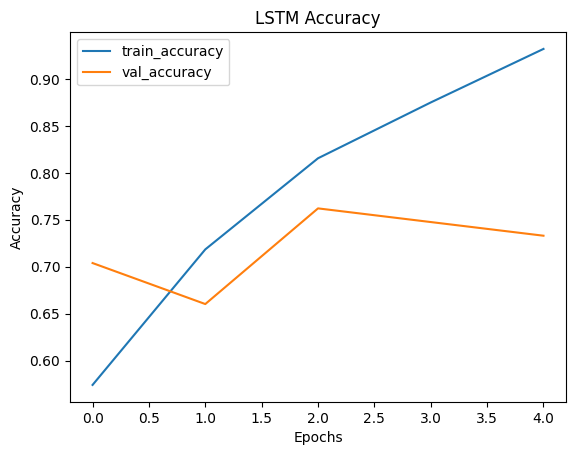

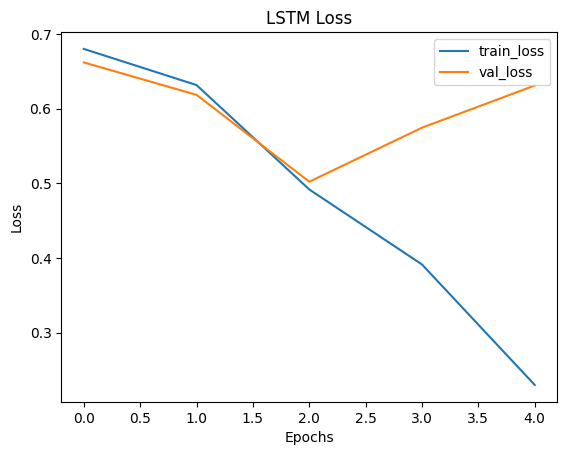

2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


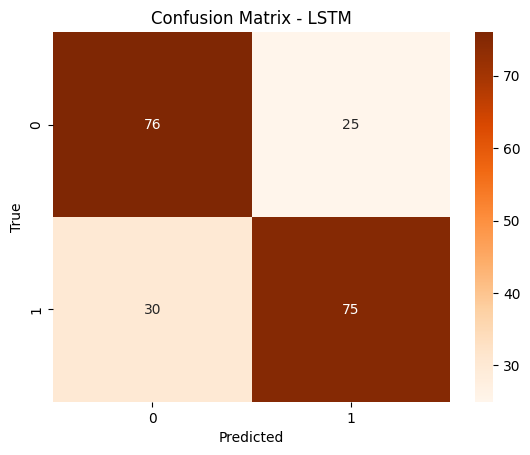

In [7]:
# Accuracy and Loss plots for LSTM
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix for LSTM
y_pred_lstm = (model.predict([X_test_pad, X_test_numerical_scaled]) > 0.5).astype("int32")
lstm_cm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(lstm_cm, annot=True, fmt="d", cmap="Oranges")
plt.title('Confusion Matrix - LSTM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
